In [0]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, transforms

from PIL import Image
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import clear_output, display

np.set_printoptions(precision=2)
plt.rcParams['figure.figsize'] = (14.0, 10.0)

In [153]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [0]:
# https://pytorch.org/docs/stable/torchvision/models.html
#normalize with provided mean and std for pretrained models
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def img2tensor(img):
    normalize = transforms.Normalize(mean=mean, std=std)

    tfms = transforms.Compose([
        transforms.Resize(512),
        transforms.ToTensor(),
        normalize
    ])
    
    img = tfms(img)
    img = img.unsqueeze(0)
    
    return img


def tensor2img(tensor, clip = False):
    img = tensor.clone().detach().cpu().numpy().squeeze().transpose(1, 2, 0)
    img = img * np.array(std) + np.array(mean)
    if clip:
      img = img.clip(0, 1)
      
    return img

# def arr2tensor(arr):
#   tensor = arr.copy().transpose(2, 0, 1)
#   tensor = (tensor - mean) / std

#   return torch.tensor(tensor)
  
def load_img_as_tensor(fname):
  img = Image.open(fname).convert('RGB') 
  return img2tensor(img).to(device)


def extract_features(x, model, layers):
    features = {}

    for i, (name, layer) in enumerate(model._modules.items()):
        x = layer(x)
        if i in layers:
            features[i] = x
    
    return features

def calc_gram_matrix(tensor):
    _, channels, height, width = tensor.size()
    tensor = tensor.view(channels, height * width)
    gram_m = torch.mm(tensor, tensor.t())
    gram_m = gram_m.div(channels * width * height)
    
    return gram_m
  
def extract_features_from_img(fname, model, layers):
  img_as_tensor = load_img_as_tensor(fname)
  features = extract_features(img_as_tensor, model, layers)

  return img_as_tensor, features    
    
def extract_gram_matrix_from_img(fname, model, layers):
  img_as_tensor, features = extract_features_from_img(fname, model, layers)
  features_gram_m = { layer: calc_gram_matrix(features[layer]) for layer in features }

  return img_as_tensor, features_gram_m

In [0]:
# style_tensor = load_img_as_tensor('ana.jpg')
# content_tensor = load_img_as_tensor('dog.jpg')
# plt.figure(figsize=(5,5))
# plt.imshow(tensor2img(style_tensor))
# plt.figure(figsize=(5,5))
# plt.imshow(tensor2img(content_tensor))

In [0]:
model = models.vgg19(pretrained = True).features

for p in model.parameters():
    p.requires_grad_(False)

model = model.to(device)

In [212]:
style_layers = [0, 5, 10, 19, 28]
style_weights = [2, 10, 10, 0.1, 0.1]
content_layers =  [0, 10, 21, 32]
content_weights = [0, 5, 1, 1]

assert len(content_layers) == len(content_weights)
assert len(style_layers) == len(style_weights)

layers = sorted(list(set((style_layers + content_layers))))
display(layers)

style_tensor, style_ftrs_gram_m = extract_gram_matrix_from_img('g.jpg', model, layers)
content_tensor1, content_ftrs1 = extract_features_from_img('s.jpg', model, layers)
content_tensor2, content_ftrs2 = extract_features_from_img('l.jpg', model, layers)
content_tensor3, content_ftrs3 = extract_features_from_img('g.jpg', model, layers)
content_tensor4, content_ftrs4 = extract_features_from_img('f.jpg', model, layers)

display(content_tensor1.shape, content_tensor2.shape)

[0, 5, 10, 19, 21, 28, 32]

torch.Size([1, 3, 512, 768])

torch.Size([1, 3, 512, 768])

In [0]:
target = content_tensor1.clone().requires_grad_(True)
# target = torch.randn(content_tensor1.shape, device=device, requires_grad=True)

# images = []

In [215]:
epochs = 501
style_loss_weights = [1e7]
lrs = [5e-2, 3e-1, 6e-2, 1e-2, 1e-3]

optimizer = optim.Adam([target], lr=1e-2)

prev_lr_idx = -1
for epoch in range(epochs):
    progress = epoch / epochs

    style_loss_weight = style_loss_weights[0]
  
    lr_idx = int(progress * len(lrs))
    if lr_idx != prev_lr_idx:
      lr = lrs[lr_idx]
      prev_lr_idx = lr_idx
      for param_group in optimizer.param_groups:
          param_group['lr'] = lr


    target_ftrs = extract_features(target, model, layers)
    
    content_loss = 0
    for l, w in zip(content_layers, content_weights):
        # m = torch.sin(torch.arange(content_ftrs[l].numel(), dtype=torch.float64).view(content_ftrs[l].shape) + (epoch/epochs) * np.pi).to(device)
        # content_ftrs[l] = content_ftrs[l] * m
        content_loss += F.mse_loss(target_ftrs[l], content_ftrs1[l]) * w
        content_loss += F.mse_loss(target_ftrs[l], content_ftrs2[l]) * w
    
    style_loss = 0
    for l, w in zip(style_layers, style_weights):
        target_ftrs_gram_m = { layer: calc_gram_matrix(target_ftrs[layer]) for layer in style_ftrs }
        style_loss += F.mse_loss(target_ftrs_gram_m[l], style_ftrs_gram_m[l]) * w
        
        
    total_loss = content_loss + style_loss * style_loss_weight

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
 
    if epoch % 10 == 0:
        print(f'epoch {epoch}', style_loss.item() * style_loss_weight, content_loss.item())
 
    if epoch % 10 == 0:
      img = tensor2img(target)
      images.append(img)


epoch 0 1205.9913569828495 23.981258392333984
epoch 10 1276.4126586262137 42.41895294189453
epoch 20 939.9586269864812 43.074119567871094
epoch 30 764.063443057239 42.77256393432617
epoch 40 662.6789399888366 41.81132888793945
epoch 50 606.9786104490049 41.33156204223633
epoch 60 575.5178790423088 41.21576690673828
epoch 70 554.4213126995601 41.21672821044922
epoch 80 538.5308031691238 41.28289031982422
epoch 90 526.1264232103713 41.35551452636719
epoch 100 515.7282066647895 41.43895721435547
epoch 110 47813.60272318125 105.81450653076172
epoch 120 18256.744369864464 73.69137573242188
epoch 130 6983.053172007203 56.675048828125
epoch 140 3653.476887848228 52.120689392089844
epoch 150 2401.979436399415 52.83827590942383
epoch 160 1818.5388762503862 54.23545837402344
epoch 170 1502.5735774543136 54.84593200683594
epoch 180 1310.375373577699 54.92355728149414
epoch 190 1180.9953139163554 54.90895462036133
epoch 200 1086.4852811209857 54.82935333251953
epoch 210 1054.8736463533714 54.89851

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


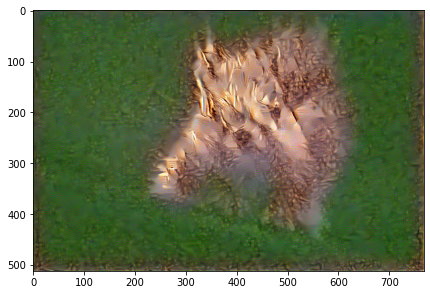

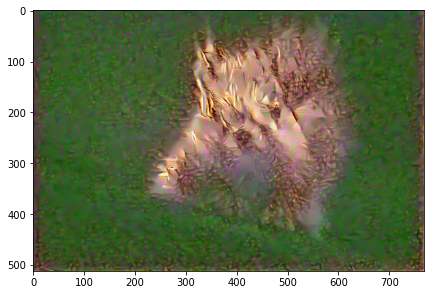

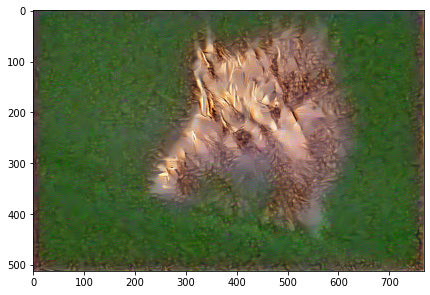

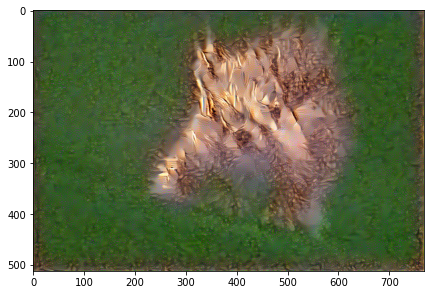

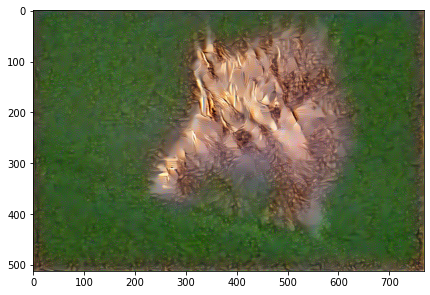

In [216]:
import os, shutil

figsize = (7, 7)
start = len(images) - 5
end = len(images)

shutil.rmtree('./output')
os.makedirs('./output')

for i in range(start, end):
  fname = f'output/{i}.jpg'
  pil_img = Image.fromarray(np.clip(np.round(images[i] * 255), 0, 255).astype('uint8'))
  pil_img.save(fname)

for i in range(start, end):
  img = images[i]
  plt.figure(figsize = figsize)
  plt.imshow(img)

In [203]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [0]:
x`# !mkdir /content/drive/'My Drive'/test
!cp *jpg /content/drive/'My Drive'/test

In [0]:
!convert -delay 100 -loop 0 *.jpg animatedGIF.gif

/bin/bash: convert: command not found
